# Toronto Bike Share

## Questions

### Due: Oct. 9, 9:30

Use the 2016 Q3, 2016 Q4, and 2017 Toronto Bikeshare ridership data available at https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/ to answer the following questions.

Station information, including real time data, is available at https://open.toronto.ca/dataset/bike-share-toronto/.

A [blog](https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62) post was written on the 2017 data set.

Use Python in a Jupyter notebook to answer the following questions. In all of the questions below interpret your results, and identify limitations.

Read through the questions below. <br>
(i) Create a brief plan of the variables that you plan to use to answer these questions, <br>
(ii) explore the variables using quantitative and visual methods <br>
(iii) rectify any inconsistencies you find through exploration <br>

1. Do casual users take shorter trips compared to members? <br>

2. Is it possible to identify if bikes are being used by tourists or residents?

3. Does season or weather affect trip duration or distance?

    (a) Define trip length in two ways, and create a variables in the data set <br>
    (b) What factors affect trip length? Do these factors differ depending on your definition?

Use linear regression to build a prediction model of trip length.

Parts of code from this lab report are from: <br>
Class Slide
https://nbviewer.jupyter.org/github/STA2453/STA2453.github.io/blob/master/sta2453-class-slides.ipynb#Another-question-<br>
Blog Post:
https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62
https://github.com/open-data-toronto/story-bike-share-ridership/blob/master/clean_data.ipynb


# Instructions
In order to store datasets downloaded from online, we need to create a "data" folder at the same location as this notebook.

# Data Downloading, Cleaning and Storage

In [317]:
import os, json, requests, zipfile, io, urllib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
import numpy as np
from geopy.distance import geodesic
import seaborn as sns

### Download all ridership data from Q3, Q4 2016 and all quarters in 2017

In [37]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "7e876c24-177c-4605-9cef-e50dd74c617f"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())

url_params = ['bikeshare-ridership-2016-q3', 'bikeshare-ridership-2016-q4', 'bikeshare-ridership-2017']

date_formats = {
    '2017 Data/Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    '2017 Data/Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    '2017 Data/Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    '2017 Data/Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M', 0],
}

for d in package['result']['resources']:
    for key, value in d.items():
        if key == 'name':
            if value == url_params[0]:
                raw_2016_Q3 = pd.read_excel(d['url'])
                # Read the datetime in the specified format
                raw_2016_Q3['trip_start_time'] = pd.to_datetime(raw_2016_Q3['trip_start_time'], format = '%d/%m/%Y %H:%M', errors='coerce') 
                # Convert the input time to the Easter timezone
                raw_2016_Q3['trip_start_time'] = raw_2016_Q3['trip_start_time'] + dt.timedelta(hours=-4)                    
                raw_2016_Q3['trip_stop_time']= pd.to_datetime(raw_2016_Q3['trip_stop_time'], format = '%d/%m/%Y %H:%M', errors='coerce') 
                raw_2016_Q3['trip_stop_time'] = raw_2016_Q3['trip_stop_time'] + dt.timedelta(hours=-4)
        
            elif value == url_params[1]:
                raw_2016_Q4 = pd.read_excel(d['url'])
                raw_2016_Q4['trip_start_time'] = pd.to_datetime(raw_2016_Q4['trip_start_time'], errors='coerce')
                raw_2016_Q4['trip_start_time'] = raw_2016_Q4['trip_start_time'] + dt.timedelta(hours=-4)
                raw_2016_Q4['trip_stop_time'] = pd.to_datetime(raw_2016_Q4['trip_stop_time'], errors='coerce') 
                raw_2016_Q4['trip_stop_time'] = raw_2016_Q4['trip_stop_time'] + dt.timedelta(hours=-4)
                
            elif value == url_params[2]:
                r = urllib.request.urlopen(d['url']).read()
                z = zipfile.ZipFile(io.BytesIO(r))
                raw_2017 = pd.DataFrame()
                for fn, fmt in date_formats.items():
                    csv = z.open(fn)
                    tmp = pd.read_csv(csv)
                    
                    # handle datetime formatting for Q4 
                    if fn == '2017 Data/Bikeshare Ridership (2017 Q4).csv':
                        tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], errors='coerce') 
                        tmp['trip_stop_time'] = pd.to_datetime(tmp['trip_stop_time'], errors='coerce') 
                        
                    else:
                        tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce') 
                        tmp['trip_start_time'] = tmp['trip_start_time'] + dt.timedelta(hours=fmt[1])                    
                        tmp['trip_stop_time'] = pd.to_datetime(tmp['trip_stop_time'], format=fmt[0], errors='coerce') 
                        tmp['trip_stop_time'] = tmp['trip_stop_time'] + dt.timedelta(hours=fmt[1])                    
                    
                    # Merge the content of the file to the main DataFrame
                    raw_2017 = pd.concat([raw_2017, tmp], sort=False).reset_index(drop=True)
                

Now let's make sure that the our data make sense visually in terms of trip start time.

In [46]:
# Remove Irrelevant Data in Q3 2016
raw_2016_Q3 = raw_2016_Q3[raw_2016_Q3['trip_start_time'].dt.month >= 7]
raw_2016_Q3 = raw_2016_Q3[raw_2016_Q3['trip_start_time'].dt.month <= 9]
raw_2016_Q3 = raw_2016_Q3[raw_2016_Q3['trip_stop_time'].dt.month >= 7]
raw_2016_Q3 = raw_2016_Q3[raw_2016_Q3['trip_stop_time'].dt.month <= 9]
raw_2016_Q3.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
0,53279,2016-07-08 21:03:00,2016-07-08 21:15:00,714,Dundas St E / Regent Park Blvd,Danforth Ave / Ellerbeck St,Member
1,53394,2016-07-08 22:15:00,2016-07-08 22:22:00,417,Riverdale Park North (Broadview Ave),Dundas St E / Regent Park Blvd,Member
2,58314,2016-07-10 13:04:00,2016-07-10 13:36:00,1904,Dundas St E / Regent Park Blvd,Queen St W / Close Ave,Member
3,60784,2016-07-10 21:45:00,2016-07-10 21:58:00,784,Union Station,Dundas St E / Regent Park Blvd,Member
4,93164,2016-07-18 09:35:00,2016-07-18 09:42:00,443,Front St W / Blue Jays Way,Front St / Yonge St (Hockey Hall of Fame),Member


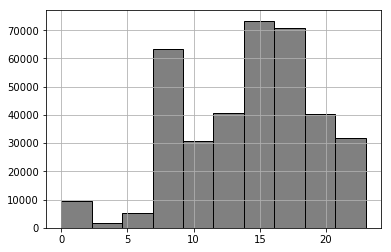

In [36]:
raw_2016_Q3['trip_start_time'].dt.hour.hist(bins=10, color="grey", edgecolor = "black")

In [39]:
# Remove Irrelevant Data in Q4 2016
raw_2016_Q4 = raw_2016_Q4[raw_2016_Q4['trip_start_time'].dt.month >= 10]
raw_2016_Q4 = raw_2016_Q4[raw_2016_Q4['trip_start_time'].dt.month <= 12]
raw_2016_Q4 = raw_2016_Q4[raw_2016_Q4['trip_stop_time'].dt.month >= 10]
raw_2016_Q4 = raw_2016_Q4[raw_2016_Q4['trip_stop_time'].dt.month <= 12]
raw_2016_Q4.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
33949,501394,2016-10-09 20:00:00,2016-10-09 20:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member
33950,501396,2016-10-09 20:00:00,2016-10-09 20:09:00,519,College St W / Major St,Bloor St / Brunswick Ave,Casual
33951,501395,2016-10-09 20:00:00,2016-10-09 20:27:00,1586,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member
33952,501397,2016-10-09 20:02:00,2016-10-09 20:29:00,1637,College St W / Borden St,25 York St (ACC/Union Station South),Member
33953,501398,2016-10-09 20:02:00,2016-10-09 20:10:00,476,Wellesley St / Queen's Park Cres,Queen St W / York St (City Hall),Member


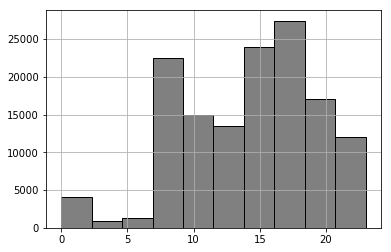

In [45]:
raw_2016_Q4['trip_start_time'].dt.hour.hist(bins=10, color="grey", edgecolor = "black")

In [51]:
# Remove Irrelevant Data in 2017
raw_2017 = raw_2017[raw_2017['trip_start_time'].dt.year == 2017]
raw_2017 = raw_2017[raw_2017['trip_stop_time'].dt.year == 2017]
raw_2017.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
58,712441,2017-01-01 00:03:00,2017-01-01 00:08:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
59,712442,2017-01-01 00:03:00,2017-01-01 00:12:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
60,712443,2017-01-01 00:05:00,2017-01-01 00:22:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
61,712444,2017-01-01 00:09:00,2017-01-01 00:26:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
62,712445,2017-01-01 00:14:00,2017-01-01 00:25:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member


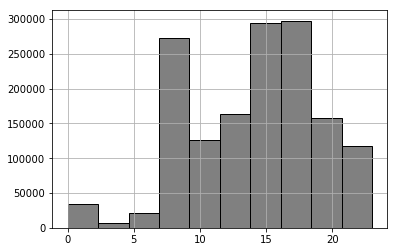

In [54]:
raw_2017['trip_start_time'].dt.hour.hist(bins=10, color="grey", edgecolor = "black")

In [55]:
# Store data in the data folder
raw_2016_Q3.to_csv('./data/bikeshare-ridership-2016-q3.csv', index=False)
raw_2016_Q4.to_csv('./data/bikeshare-ridership-2016-q4.csv', index=False)
raw_2017.to_csv('./data/bikeshare-ridership-2017.csv', index=False)

In [543]:
# Read tables directly from the data folder if initial download has been done
raw_2016_Q3 = pd.read_csv('./data/bikeshare-ridership-2016-q3.csv')
raw_2016_Q4 = pd.read_csv('./data/bikeshare-ridership-2016-q4.csv')
raw_2017 = pd.read_csv('./data/bikeshare-ridership-2017.csv')


### Download and store the station id and location data

In [712]:
# Download and Store Station Data
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "2b44db0d-eea9-442d-b038-79335368ad5a"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())

station_url = package['result']['resources']
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)


In [249]:
bikeshare_stations = pd.read_csv('./data/bikeshare_stations.csv')

## Merge Ridership and Station Data

Try and merge the Q3 2016 ridership data and station data. We found out that are still missing values for station ids. This is because of the mismatch between station names in the two tables.

In [250]:
Q3_2016 = pd.merge(raw_2016_Q3, bikeshare_stations, left_on='from_station_name', \
                   right_on='name', how='left')

Q3_2016 = Q3_2016.rename(columns={"station_id": "from_station_id", "lat": "from_lat", "lon":"from_lon"})
Q3_2016 = Q3_2016.drop(columns='name', axis = 1)

Q3_2016 = pd.merge(Q3_2016, bikeshare_stations, left_on='to_station_name', \
                   right_on='name', how='left')

Q3_2016 = Q3_2016.rename(columns={"station_id": "to_station_id", "lat": "to_lat", "lon":"to_lon"})
Q3_2016 = Q3_2016.drop(columns='name', axis = 1)

Q3_2016.head()


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,from_station_id,from_lat,from_lon,to_station_id,to_lat,to_lon
0,53279,2016-07-08 21:03:00,2016-07-08 21:15:00,714,Dundas St E / Regent Park Blvd,Danforth Ave / Ellerbeck St,Member,7100.0,43.660207,-79.361275,7095.0,43.677076,-79.356670
1,53394,2016-07-08 22:15:00,2016-07-08 22:22:00,417,Riverdale Park North (Broadview Ave),Dundas St E / Regent Park Blvd,Member,7097.0,43.671172,-79.354704,7100.0,43.660207,-79.361275
2,58314,2016-07-10 13:04:00,2016-07-10 13:36:00,1904,Dundas St E / Regent Park Blvd,Queen St W / Close Ave,Member,7100.0,43.660207,-79.361275,7136.0,43.640634,-79.435841
3,60784,2016-07-10 21:45:00,2016-07-10 21:58:00,784,Union Station,Dundas St E / Regent Park Blvd,Member,7033.0,43.645609,-79.380386,7100.0,43.660207,-79.361275
4,93164,2016-07-18 09:35:00,2016-07-18 09:42:00,443,Front St W / Blue Jays Way,Front St / Yonge St (Hockey Hall of Fame),Member,7059.0,43.643473,-79.390477,NaN,NaN,NaN


Percentage of missing station id's in Q3 2016

In [251]:
# 26.89%
np.isnan(Q3_2016['from_station_id']).sum() / len(Q3_2016['from_station_id']) 

0.2689933594313214

In [252]:
# 27.26%
np.isnan(Q3_2016['to_station_id']).sum() / len(Q3_2016['to_station_id'])

0.2725652835095718

Count all station names that has NaN station id.

In [253]:
Q3_2016[np.isnan(Q3_2016['from_station_id'])].groupby('from_station_name') \
        ['trip_id','from_station_name'].nunique().sort_values('trip_id', ascending=False)[:10]


,trip_id,from_station_name
from_station_name,,
Widmer St / Adelaide St,5709,1
Simcoe St / Wellington St W,5635,1
Dundas St / Yonge St,5455,1
Princess St / Adelaide St,4172,1
HTO Park (Queen's Quay W),3986,1
Sherbourne St / Wellesley St,3945,1
Fort York Blvd / Capreol Crt,3870,1
Beverly St / Dundas St W,3732,1
Bay St / Bloor St W,3711,1


In [254]:
# Use regular expression to check if above station names in bikeshare_stations
pat = r'^College'
bikeshare_stations[bikeshare_stations['name'].str.contains(pat)]

,station_id,name,lat,lon
7,7007.0,College St / Huron St,43.658148,-79.398167
23,7023.0,College St / Borden St,43.657100,-79.405600
75,7077.0,College Park South,43.659777,-79.382767
76,7078.0,College St / Major St,43.657600,-79.403200
185,7199.0,College St / Markham St,43.656389,-79.409167
188,7204.0,College St / Crawford St,43.655000,-79.418889
270,7293.0,College St / McCaul St,43.659060,-79.393771
354,7389.0,College Park- Gerrard Entrance,43.658938,-79.383518
376,7418.0,College Park - Yonge St Entrance,43.659880,-79.382790


#### Now, we replace the mismatched values to match names from station_name and merge again. Manually finding out these names were a lot of work.

In [255]:
# Found following mismatch station names:
old_station_names = ['Fort York  Blvd / Capreol Crt', 
                    'Fort York Blvd / Capreol Ct',
                    'HTO Park (Queen\'s Quay W)',
                    'Dundas St / Yonge St',
                    'College St W / Huron St',
                    'College St W / Major St',
                    'Queens Park / Bloor St W',
                    'Front St / Yonge St (Hockey Hall of Fame)',
                    'Widmer St / Adelaide St ',
                    'Sherbourne St / Wellesley St',
                    'St George St / Bloor St W',
                    '424 Wellington St. W',
                    'Beverly  St / Dundas St W',
                    'Beverley St / Dundas St W',
                    'Beverly St / College St W',
                    'Princess St / Adelaide St',
                    'Temperance St / Yonge St',
                    'University Ave / King St W',
                    'Bay St / Bloor St W',
                    'Wellesley St E / Yonge St Green P',
                    'University Ave / College St',
                    'Simcoe St / Dundas St W',
                    'Simcoe St / Wellington St W',
                    'Ontario Place Blvd / Remembrance Dr',
                    'Bremner Blvd / Spadina Ave',
                    '25 York St (ACC/Union Station South)'
                    ]
                     
new_station_names = ['Fort York  Blvd / Capreol Ct', 
                    'Fort York  Blvd / Capreol Ct',
                    'HTO Park (Queens Quay W)',
                    'Dundas St W / Yonge St',
                    'College St / Huron St',
                    'College St / Major St',
                    'Queen\'s Park / Bloor St W',
                    'Front St W / Yonge St (Hockey Hall of Fame)',
                    'Widmer St / Adelaide St W',
                    'Sherbourne St / Wellesley St E',
                    'St. George St / Bloor St W',
                    '424 Wellington St W',
                    'Beverley  St / Dundas St W',
                    'Beverley  St / Dundas St W',
                    'Beverley St / College St',
                    'Princess St / Adelaide St E',
                    'Temperance St. Station',
                    'York St / King St W - SMART',
                    'Cumberland Ave / Bay St SMART',
                    'Wellesley St E / Yonge St (Green P)',
                    'University Ave / College St (West)',
                    'Dundas St W / St. Patrick St',
                    'Simcoe St / Wellington St South',
                    'Spadina Ave / Fort York Blvd',
                    'Ontario Place Blvd / Lakeshore Blvd W',
                    '25 York St – Union Station South'
                    ]

In [256]:
# Q3 2016
Q3_2016 = raw_2016_Q3.replace(old_station_names, new_station_names)

Q3_2016 = pd.merge(Q3_2016, bikeshare_stations, left_on='from_station_name', \
                   right_on='name', how='left')

Q3_2016 = Q3_2016.rename(columns={"station_id": "from_station_id", "lat": "from_lat", "lon":"from_lon"})
Q3_2016 = Q3_2016.drop(columns='name', axis = 1)

Q3_2016 = pd.merge(Q3_2016, bikeshare_stations, left_on='to_station_name', \
                   right_on='name', how='left')

Q3_2016 = Q3_2016.rename(columns={"station_id": "to_station_id", "lat": "to_lat", "lon":"to_lon"})
Q3_2016 = Q3_2016.drop(columns='name', axis = 1)

In [257]:
# Q4 2016
Q4_2016 = raw_2016_Q4.replace(old_station_names, new_station_names)

Q4_2016 = pd.merge(Q4_2016, bikeshare_stations, left_on='from_station_name', \
                   right_on='name', how='left')

Q4_2016 = Q4_2016.rename(columns={"station_id": "from_station_id", "lat": "from_lat", "lon":"from_lon"})
Q4_2016 = Q4_2016.drop(columns='name', axis = 1)

Q4_2016 = pd.merge(Q4_2016, bikeshare_stations, left_on='to_station_name', \
                   right_on='name', how='left')

Q4_2016 = Q4_2016.rename(columns={"station_id": "to_station_id", "lat": "to_lat", "lon":"to_lon"})
Q4_2016 = Q4_2016.drop(columns='name', axis = 1)

In [258]:
# 2017
Y_2017 = raw_2017.replace(old_station_names, new_station_names)
Y_2017 = Y_2017.drop(columns=['from_station_id', 'to_station_id'])

Y_2017 = pd.merge(Y_2017, bikeshare_stations, left_on='from_station_name', \
                   right_on='name', how='left')

Y_2017 = Y_2017.rename(columns={"station_id": "from_station_id", "lat": "from_lat", "lon":"from_lon"})
Y_2017 = Y_2017.drop(columns='name', axis = 1)

Y_2017 = pd.merge(Y_2017, bikeshare_stations, left_on='to_station_name', \
                   right_on='name', how='left')

Y_2017 = Y_2017.rename(columns={"station_id": "to_station_id", "lat": "to_lat", "lon":"to_lon"})
Y_2017 = Y_2017.drop(columns='name', axis = 1)

As we can see below, compared to before correcting mismatched station names, the missing precentage has dropped from around 27% to 5%. This we rescued around 22% of the data that could have been dropped if we did not do the manual correction.

In [14]:
# 4.25%
np.isnan(Q3_2016['from_station_id']).sum() / len(Q3_2016['from_station_id']) 

# 4.33%
np.isnan(Q3_2016['to_station_id']).sum() / len(Q3_2016['to_station_id'])

# 5.13%
np.isnan(Q4_2016['from_station_id']).sum() / len(Q4_2016['from_station_id']) 

# 5.04%
np.isnan(Q4_2016['to_station_id']).sum() / len(Q4_2016['to_station_id'])

# 5.63% 
np.isnan(Y_2017['from_station_id']).sum() / len(Y_2017['from_station_id']) 

# 5.74%
np.isnan(Y_2017['to_station_id']).sum() / len(Y_2017['to_station_id'])

0.05735541365762721

In [15]:
# check how many lines still have NaN values in 2017 table
Y_2017.isnull().sum(axis = 0)

trip_id                      0
trip_start_time              0
trip_stop_time               0
trip_duration_seconds        0
from_station_name            0
to_station_name              0
user_type                    0
from_station_id          83950
from_lat                 83950
from_lon                 83950
to_station_id            85592
to_lat                   85592
to_lon                   85592
dtype: int64

In [259]:
Q3_2016 = Q3_2016.dropna()
Q4_2016 = Q4_2016.dropna()
Y_2017 = Y_2017.dropna()
ridership = pd.concat([Q3_2016, Q4_2016, Y_2017])

ridership.to_csv('./data/bikeshare-ridership-2016q3q4-2017-clean.csv', index=False)

print('The cleaned aggregate ridership data has %s lines' % str(len(ridership)))


The cleaned aggregate ridership data has 1792853 lines


In [565]:
# Read tables from the data folder if clearning has been done
ridership = pd.read_csv('./data/bikeshare-ridership-2016q3q4-2017-clean.csv')

## Download, Process and Store Weather 

In [ ]:
# Weather data
weather = pd.DataFrame()
weather_list = []
base_url = 'http://climate.weather.gc.ca/climate_data/daily_data_e.html?'
newcolnames = {'DAY' : 'Date','Mean Temp Definition' + chr(176) +'C': 'Mean_Temp', 
                   'Total Precip Definitionmm' :'Total_Precip'}
mon_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# 2016
for i in range(6, 13):
    query_url = 'StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2016&Month=' + str(i) + '#'
    tmp_weather_df = pd.read_html(base_url + query_url)
    if i in ['1', '3', '5', '7', '8', '10', '12']:
        end_id = 31
    elif i == 2:
        end_id = 28
    else:
        end_id = 30
    tmp_weather_df = tmp_weather_df[0][0:end_id]
    # rename columns
    tmp_weather_df.rename(columns = newcolnames, inplace = True)
    # replace trace rain values with 0
    tmp_weather_df = tmp_weather_df[['Date', 'Mean_Temp', 'Total_Precip']].replace('LegendTT', 0)
    weather_list.append(tmp_weather_df)

# format date column
year_16 = '2016'
for m in range(6):
    # create date that can be merged with ridership data
    weather_list[m]['Date'] = year_16 + '-' + mon_list[m+6] + '-' + weather_list[m]['Date']
    weather = pd.concat([weather, weather_list[m]], sort=False).reset_index(drop=True)
    
# 2017 
weather_list = []
for i in range(1, 13):
    query_url = 'StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=' + str(i) + '#'
    tmp_weather_df = pd.read_html(base_url + query_url)
    if i in ['1', '3', '5', '7', '8', '10', '12']:
        end_id = 31
    elif i == 2:
        end_id = 28
    else:
        end_id = 30
    tmp_weather_df = tmp_weather_df[0][0:end_id]
    # rename columns
    tmp_weather_df.rename(columns = newcolnames, inplace = True)
    # replace trace rain values with 0
    tmp_weather_df = tmp_weather_df[['Date', 'Mean_Temp', 'Total_Precip']].replace('LegendTT', 0)
    weather_list.append(tmp_weather_df)

# format date column
year_17 = '2017'
for m in range(12):
    # create date that can be merged with ridership data
    weather_list[m]['Date'] = year_17 + '-' + mon_list[m] + '-' + weather_list[m]['Date']
    weather = pd.concat([weather, weather_list[m]], sort=False).reset_index(drop=True)

In [490]:
# replace trace rain values with 0 and adjust format for specific values properly
weather = weather[['Date', 'Mean_Temp', 'Total_Precip']].replace({'LegendTT':0, 'LegendMM':0, '20.7LegendEE':20.7, '15.6LegendEE':15.6, '0.0LegendEE':0})

weather.head()

,Date,Mean_Temp,Total_Precip
0,2016-07-01,16.2,0.0
1,2016-07-02,23.3,0.2
2,2016-07-03,20.3,0.0
3,2016-07-04,20.3,5.4
4,2016-07-05,20.6,5.8


In [492]:
# save table
weather.to_csv('./data/weather.csv', index=False)

In [493]:
# Read tables from the data folder if initial download has been done
weather = pd.read_csv('./data/weather.csv')

## Merge weather data with ridership data

In [494]:
ridership_weather = ridership
ridership_weather['trip_start_date'] = pd.to_datetime(pd.to_datetime(ridership['trip_start_time']).dt.date)
weather['Date'] = pd.to_datetime(weather['Date'])
ridership_weather = pd.merge(ridership_weather, weather, left_on='trip_start_date', 
                             right_on='Date', how='left')
ridership_weather = ridership_weather.drop(columns = ['trip_start_date', 'Date'])
ridership_weather = ridership_weather.dropna()
ridership = ridership.drop(columns = 'trip_start_date')


## Create Trip Distance Measure

We use geodesic distance to approximate actual trip route distance.

In [568]:
from_lat = ridership['from_lat'].values
from_lon = ridership['from_lon'].values
to_lat = ridership['to_lat'].values
to_lon = ridership['to_lon'].values

from_coordinates = list(zip(from_lat, from_lon))
to_coordinates = list(zip(to_lat, to_lon))

distances = []
# for loop takes around 6-7 minutes
for i in range(len(to_coordinates)):
    distances.append(geodesic(from_coordinates[i], to_coordinates[i]).meters)
ridership['distance'] = distances

In [571]:
# add distance to ridership_weather (ridership, weather, distance -> rwd)
rwd = pd.merge(ridership_weather, ridership[['trip_id', 'distance']], left_on='trip_id', \
                   right_on='trip_id', how='left')
rwd['distance'] = rwd['distance_x']
rwd = rwd.drop(columns=['distance_x', 'distance_y'], axis = 1)

In [572]:
# final dataset
rwd.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,from_station_id,from_lat,from_lon,to_station_id,to_lat,to_lon,Mean_Temp,Total_Precip,distance
0,53279,2016-07-08 21:03:00,2016-07-08 21:15:00,714,Dundas St E / Regent Park Blvd,Danforth Ave / Ellerbeck St,Member,7100.0,43.660207,-79.361275,7095.0,43.677076,-79.356670,10.9,0.0,1910.687075
1,53394,2016-07-08 22:15:00,2016-07-08 22:22:00,417,Riverdale Park North (Broadview Ave),Dundas St E / Regent Park Blvd,Member,7097.0,43.671172,-79.354704,7100.0,43.660207,-79.361275,10.9,0.0,1328.561727
2,58314,2016-07-10 13:04:00,2016-07-10 13:36:00,1904,Dundas St E / Regent Park Blvd,Queen St W / Close Ave,Member,7100.0,43.660207,-79.361275,7136.0,43.640634,-79.435841,15.7,0.0,6396.664210
3,60784,2016-07-10 21:45:00,2016-07-10 21:58:00,784,Union Station,Dundas St E / Regent Park Blvd,Member,7033.0,43.645609,-79.380386,7100.0,43.660207,-79.361275,15.7,0.0,2237.753837
4,93164,2016-07-18 09:35:00,2016-07-18 09:42:00,443,Front St W / Blue Jays Way,Front St W / Yonge St (Hockey Hall of Fame),Member,7059.0,43.643473,-79.390477,7048.0,43.646144,-79.377962,24.3,0.0,1052.455050


### Create RWD (ridership, weather and distance) dataset for analysis

In [573]:
# save file
rwd.to_csv('./data/ridership-weather-distance.csv', index=False)

# Question 1: Do casual users take shorter trips compared to members?

The variables needed to answer this question is trip_duration_seconds, which we will turn into minutes for better visualization, as well as distance created from the previous secton. We compare these in both the Member and Casual user groups.

Intuitively, we expect the memebers to spend less time and travels a shorter distance on their bikes. This is because they are more familiar with the system and they know excactly where they are going. On the other hand, casual members are mostly tourists to the city and they will wander around the city more. As a member myself, I often see tourists spend more time adjusting their bikes and figure out how the system work.

Let's see if the data would tell us this as well.

In [484]:
# read dataset
rwd = pd.read_csv('./data/ridership-weather-distance.csv')

## 1.1 Visualizing duration and distance by user group

In [575]:
import warnings
warnings.filterwarnings('ignore')

# filter data with trip durations less than 3 hours (10800 seconds)
ridership_trim = rwd[rwd['trip_duration_seconds'] <= 10800]
ridership_trim['trip_duration_minutes'] = ridership_trim['trip_duration_seconds'].divide(60)


## Scatterplot

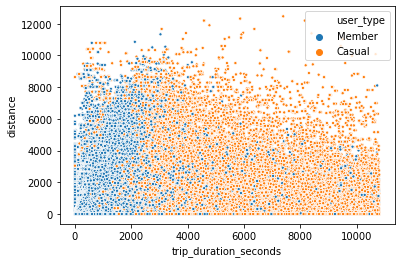

In [310]:
# takes 6 minutes to plot all the data points
sns.scatterplot(x="trip_duration_seconds", y="distance", \
                hue="user_type", data=ridership_trim, s=10)


As we can see from the above plot, there are more blue dots representing member riders on the left and bottom end of the plot. This means that they spend less time on their bikes and travel shorter distances. Members normally do not wander around the city and know exactly where they are heading so this makes sense.

## Histograms and Boxplots

Text(0, 0.5, 'count')

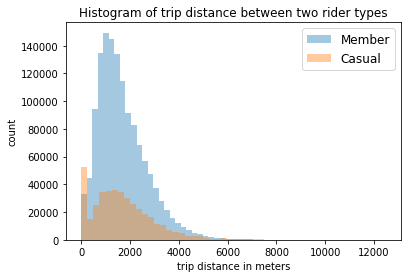

In [576]:
num_bins = 50
member_ridership = ridership_trim[ridership_trim['user_type'] == 'Member']
casual_ridership = ridership_trim[ridership_trim['user_type'] == 'Casual']
sns.distplot(member_ridership['distance'], bins = num_bins, kde=False, label='Member')
sns.distplot(casual_ridership['distance'], bins = num_bins, kde=False, label='Casual')

# plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram of trip distance between two rider types')
plt.xlabel('trip distance in meters')
plt.ylabel('count')

Text(0, 0.5, 'count')

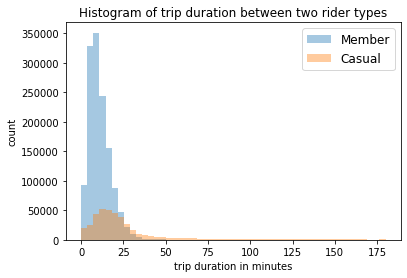

In [577]:
sns.distplot(member_ridership['trip_duration_minutes'], bins = num_bins, kde=False, label='Member')
sns.distplot(casual_ridership['trip_duration_minutes'], bins = num_bins, kde=False, label='Casual')

# plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram of trip duration between two rider types')
plt.xlabel('trip duration in minutes')
plt.ylabel('count')

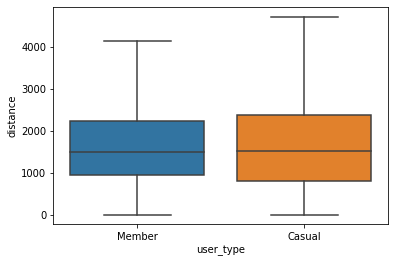

In [391]:
sns.boxplot(data=ridership_trim, x='user_type', y='distance', showfliers=False)

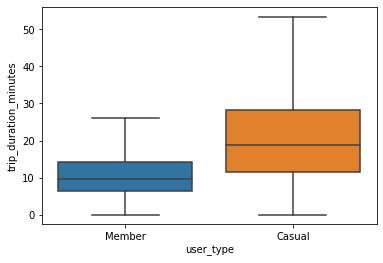

In [392]:
sns.boxplot(data=ridership_trim, x='user_type', y='trip_duration_minutes', showfliers=False)

From the histograms for trip durations and trip distances between the two rider groups, we see that there are more member trips than casual trips overall. Casual riders spend longer time on their bikes than members. This makes sense because the majority of casual riders are visitors to the city. In terms of distance traveled, the means are similar, but the number of trips made by members drops drastically when trip distances are longer, indicating a pattern towards shorter trips for members. On the other hand, the casual members have a relatively even distribution for both trip distance and trip duration.

To analyze the data more easily, we take daily averages of duration, distance, precipitation, temperature for members and casual users. This also roughly enforces an independence assumption on our data points.

In [578]:
# format columns
rwd['trip_start_time'] = pd.to_datetime(rwd['trip_start_time'])
rwd['Total_Precip'] = pd.to_numeric(rwd['Total_Precip'])
rwd['Mean_Temp'] = pd.to_numeric(rwd['Mean_Temp'])

# remove outlier trips greater than three hours
rwd = rwd[rwd['trip_duration_seconds'] <= 10800]

# generate seperate time measurements
rwd['Day'] = rwd['trip_start_time'].dt.day
rwd['Month'] = rwd['trip_start_time'].dt.month
rwd['start_hr'] = rwd['trip_start_time'].dt.hour
rwd['start_min'] = rwd['trip_start_time'].dt.minute

mean_by_day = rwd.groupby(['Month','Day', 'user_type'], as_index=False).mean()

Y = mean_by_day['trip_duration_seconds']
Z = mean_by_day['distance']
X = mean_by_day['Total_Precip']
X1 = mean_by_day['Mean_Temp']
T = mean_by_day['user_type']

df = pd.DataFrame({'dur': Y, 'precip': X, 'temp':X1, 'dist': Z, 'user_type': T})
df['log_dur']=df['dur'].transform(lambda x: np.log(x))
df['log_precip']=df['precip'].transform(lambda x: np.log(x+1))
df.reset_index(inplace=True)

,index,dur,precip,temp,dist,user_type,log_dur,log_precip
0,0,2090.371429,0.0,-0.4,1812.264906,Casual,7.645097,0.000000
1,1,673.383202,0.0,-0.4,1530.674585,Member,6.512315,0.000000
2,2,1727.682927,0.0,0.4,1456.394787,Casual,7.454536,0.000000
3,3,611.091703,0.0,0.4,1492.437213,Member,6.415247,0.000000
4,4,919.500000,15.8,3.1,1348.223462,Casual,6.823830,2.821379


In [579]:
# remove outlier trips greater than three hours
rwd = rwd[rwd['trip_duration_seconds'] <= 10800]

# generate seperate time measurements
rwd['Day'] = rwd['trip_start_time'].dt.day
rwd['Month'] = rwd['trip_start_time'].dt.month
rwd['start_hr'] = rwd['trip_start_time'].dt.hour
rwd['start_min'] = rwd['trip_start_time'].dt.minute

mean_by_day = rwd.groupby(['Month','Day', 'user_type'], as_index=False).mean()

Y = mean_by_day['trip_duration_seconds']
Z = mean_by_day['distance']
X = mean_by_day['Total_Precip']
X1 = mean_by_day['Mean_Temp']
T = mean_by_day['user_type']


df = pd.DataFrame({'dur': Y, 'precip': X, 'temp':X1, 'dist': Z, 'user_type': T})
df['log_dur']=df['dur'].transform(lambda x: np.log(x))
df['log_precip']=df['precip'].transform(lambda x: np.log(x+1))
df.reset_index(inplace=True)
df.head()

,index,dur,precip,temp,dist,user_type,log_dur,log_precip
0,0,2090.371429,0.0,-0.4,1812.264906,Casual,7.645097,0.000000
1,1,673.383202,0.0,-0.4,1530.674585,Member,6.512315,0.000000
2,2,1727.682927,0.0,0.4,1456.394787,Casual,7.454536,0.000000
3,3,611.091703,0.0,0.4,1492.437213,Member,6.415247,0.000000
4,4,919.500000,15.8,3.1,1348.223462,Casual,6.823830,2.821379


### Scatterplot of Duration vs Distance with Everyday Average

Let us look at a scatterplot again with the daily average values of durations and distances.

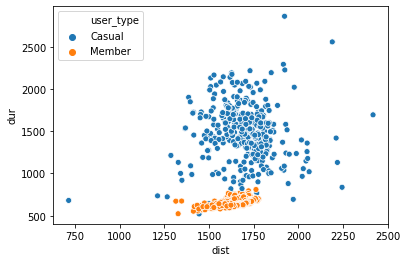

In [661]:
sns.scatterplot(y = 'dur', x = 'dist', hue = 'user_type', data = df)

In this scatterplot, we can clearly see that casual users spend longer time on their bikes on average. 

## 1.2 Quantitative Models

In [581]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Duration vs Member Type

In [582]:
model = smf.ols("dur ~ C(user_type)", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    dur   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     2168.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):          1.48e-218
Time:                        16:44:03   Log-Likelihood:                -4939.4
No. Observations:                 716   AIC:                             9883.
Df Residuals:                     714   BIC:                             9892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1492

### Distance vs Member Type

In [583]:
model = smf.ols("dist ~ C(user_type)", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     29.83
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           6.53e-08
Time:                        16:44:07   Log-Likelihood:                -4494.0
No. Observations:                 716   AIC:                             8992.
Df Residuals:                     714   BIC:                             9001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1696

Form the linear regression results above, we notice that the p-values for both the intercepts as well as the slopes are smaller than 0.01. This means that there is a linear relationship between duration/distance and the member group. (duration/distance will decrease if the user is a member)

In [584]:
# df.groupby('user_type')['dur'].mean().diff()
stats.ttest_ind(df[df['user_type']=='Member']['dur'], df[df['user_type']=='Casual']['dur'])


Ttest_indResult(statistic=-46.56709016796376, pvalue=1.4773694882696736e-218)

In [585]:
# df.groupby('user_type')['dist'].mean().diff()
stats.ttest_ind(df[df['user_type']=='Member']['dur'], df[df['user_type']=='Casual']['dur'])


Ttest_indResult(statistic=-46.56709016796376, pvalue=1.4773694882696736e-218)

From the above t-tests, we can see that the p-values are extremely small, indicating again there is a statistically significant difference between the two rider groups when it comes to their trip durations and distance. 


# Question 2: How to identify if a biker is a tourist or a resident?

In this problem, the variables that matter are duration and distance, as we see previously that members and casual riders differ significantly in these aspects. The weather data is not relevant for determining the user type.

Here, we use logistic regression to predict user type with trip duation and trip distance as independent variables.

### Logistic Regression

In [686]:
# casual is 1 and member is 0
df['user_type_Casual'] = pd.get_dummies(df, columns = ['user_type'])['user_type_Casual']

np.random.seed(2019)
df_train = df.sample(frac = 0.75) # 75% data is random sample to train 
df_test = df.drop(index = df_train.index) #25% test
print('Training Data Shape:', df_train.shape, '\nTest Data Shape:', df_test.shape, df.shape) # check df shape

df_train_X = df_train[['dist', 'dur']] #training features
df_train_Y = df_train[['user_type_Casual']] #training dependent variable

df_test_X = df_test[['dist', 'dur']] #test features
df_test_Y = df_test[['user_type_Casual']] #test dependent variable 

# create logistic regression object
logreg = linear_model.LogisticRegression()

# train the model
logreg.fit(df_train_X, df_train_Y)

# predict using test set
df_Y_pred_test = regr.predict(df_test_X)

# predict using training set
df_Y_pred_train = regr.predict(df_train_X)

train_accuracy = 1 - len(np.where((np.array(df_Y_pred_train) - df_train_Y.values.reshape(-1,)) != 0)) / len(df_Y_pred_train)
test_accuracy = 1 - len(np.where((np.array(df_Y_pred_test) - df_test_Y.values.reshape(-1,)) != 0)) / len(df_Y_pred_test)

print("Test MSE: %.2f" % mean_squared_error(df_test_Y, df_Y_pred_test))
print("Train MSE: %.2f" % mean_squared_error(df_train_Y, df_Y_pred_train))
print("Training Accuracy: %.2f%%" % (train_accuracy *100))
print("Testing Accuracy: %.2f%%" % (test_accuracy *100))

Training Data Shape: (537, 9) 
Test Data Shape: (179, 9) (716, 9)
Test MSE: 0.02
Train MSE: 0.01
Training Accuracy: 99.81%
Testing Accuracy: 99.44%


### Logistic Regression with Cross Validation

In [709]:
# use 10-fold cross-validation to evaluate the dataset again
from sklearn.model_selection import train_test_split, cross_validate

X = df[['dist', 'dur']]
y = df[['user_type_Casual']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2019)
cv_results = cross_validate(logreg, X, y, cv=10)

print(cv_results['test_score'])
print("Average 10-fold Cross-Validation Accuracy: %.2f%%" % (cv_results['test_score'].mean()))


[0.91666667 0.97222222 0.98611111 1.         1.         1.
 1.         1.         1.         0.97142857]
Average 10-fold Cross-Validation Accuracy: 0.98%


In [710]:
# Only using distance as input
X = df[['dist']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2019)
cv_results = cross_validate(logreg, X, y, cv=10)
print(cv_results['test_score'])
print("Average 10-fold Cross-Validation Accuracy with only Distance: %.2f%%" % (cv_results['test_score'].mean()))


[0.73611111 0.79166667 0.48611111 0.38888889 0.34722222 0.13888889
 0.51388889 0.55555556 0.8        0.85714286]
Average 10-fold Cross-Validation Accuracy with only Distance: 0.56%


In [711]:
# Only using duration as input
X = df[['dur']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)
cv_results = cross_validate(logreg, X, y, cv=10)
print(cv_results['test_score'])
print("Average 10-fold Cross-Validation Accuracy with only Duration: %.2f%%" % (cv_results['test_score'].mean()))

[0.875      0.94444444 0.98611111 0.98611111 1.         1.
 1.         1.         1.         0.95714286]
Average 10-fold Cross-Validation Accuracy with only Duration: 0.97%


We can see from the above logistic regression results that with trip duration and distance, we can accurately predict the user type of a trip. We achieved average cross-validation accuacy of 98%. Looking at how well distance or duration can predict user type on their own, duration is more effective than distance travelled when we classify user type. This aligns with what we saw earlier at the end of section 1.1, where the orange data points in the scatterplot all have duration less than 1000 seconds, and the blue ones are mostly greater than 1000. If we only look at the trip distance metric, it is harder to tell which user group a data point belongs to.

# Question 3: Do season or weather affect trip duration and distance?

To answer this question, we need look at relationships between trip length vs. average temperature and precipitation. Trip length can be defined in two ways. It can be the duration of the trip or the distance of the trip.

We expect both trip durations and distances to drop when it is colder or when it is raniy.

## 3.1 Visualizaing Relationship betwen Trip Length and Weather

### Duration vs. Average Precipitation

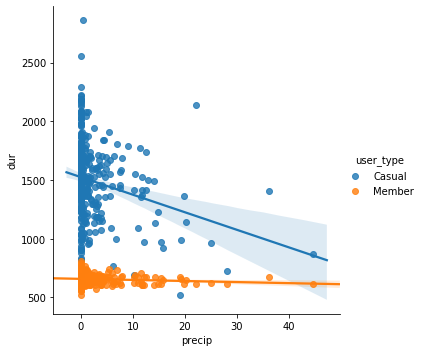

In [663]:
sns.lmplot(y = 'dur', x = 'precip', hue = 'user_type', data = df)

### Distance vs. Average Precipitation

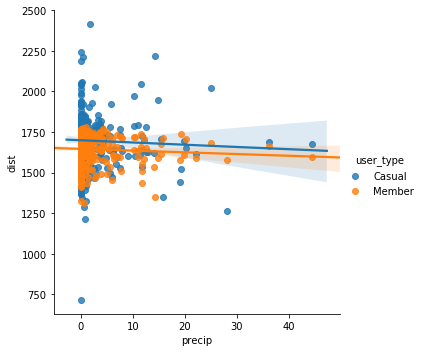

In [665]:
sns.lmplot(y = 'dist', x = 'precip', hue = 'user_type', data = df)

First of all, we can see that overall there are way less trips being made when it is rainy. There is also a tendency for shorter trips for casual members, and rain doesn't seem to influence members too much despite there are less trip being made. This is because members are residents in the city and sometimes they will need to get home regardless if it is rainy or not, and tourists might take a taxi back to their hotels instead.

### Duration vs. Average Temperature

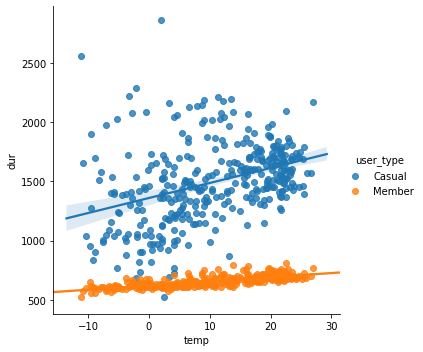

In [667]:
sns.lmplot(y = 'dur', x = 'temp', hue = 'user_type', data = df)

### Distance vs. Average Temperature

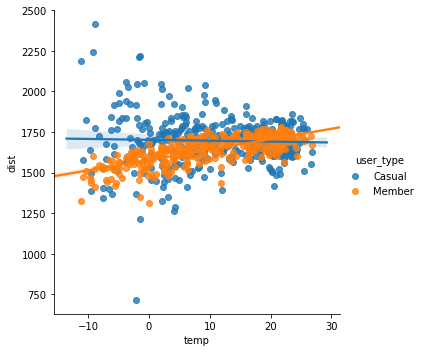

In [589]:
sns.lmplot(y = 'dist', x = 'temp', hue = 'user_type', data = df)

There are obvious tendency to spend less time in the cold weather for both groups. Members also travel less when it is cold. Casual member does not seem to care too much about how cold it was, though there is an increase in the variance of the distance travelled when the temperature is low.

## 3.2 Quantitative Models 

### Duration vs Temperature

In [590]:
model = smf.ols("dur ~ temp + precip + C(user_type)", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    dur   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     877.7
Date:                Mon, 07 Oct 2019   Prob (F-statistic):          1.17e-238
Time:                        16:44:24   Log-Likelihood:                -4885.1
No. Observations:                 716   AIC:                             9778.
Df Residuals:                     712   BIC:                             9797.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1424

### Distance vs Temperature and Preception

In [657]:
model = smf.ols("dist ~ temp + precip + C(user_type)", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     23.72
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.22e-14
Time:                        21:29:20   Log-Likelihood:                -4474.5
No. Observations:                 716   AIC:                             8957.
Df Residuals:                     712   BIC:                             8975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1668

From the above multiple linear regression models, based on the p-values in the first table, we can see that duration is highly correlated with temperature, precipitation and the type of user. Distance are related with temperature, user type. But precipitation does not influence the distance of bike trips since its p-value is larger than 0.1. This echoes the visualization of the plot of distance vs precipitation, where the regression lines are flat. However, we do see in that plot that a smaller number of data points are present when precipitation is high. This means people are making less trips when it is rainy.